# Workplace Safety PPE Detection System - Model Training with YOLOv8
## DeMarcus Crump & Chloe Tu | ITAI 1378 | Final Project

This notebook trains a YOLOv8 nano model on our resplit dataset. We're using transfer learning from a pre-trained model, configuring data augmentation strategies, and monitoring training metrics to achieve optimal PPE detection performance.

## Mount Google Drive

Mounting Google Drive to access the dataset created in Notebook 1 and to save model checkpoints persistently.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

print("=" * 60)
print("✓ Google Drive mounted successfully!")
print("✓ Dataset and model checkpoints will be saved to Drive")
print("=" * 60)

Mounted at /content/drive
✓ Google Drive mounted successfully!
✓ Dataset and model checkpoints will be saved to Drive


## Setup and GPU Verification

Checking GPU availability is critical since training deep learning models on CPU takes significantly longer. We're using the Ultralytics library which provides the YOLOv8 implementation.

In [2]:
# Install YOLOv8 library
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Verify GPU availability for faster training
print("System Information:")
print("=" * 60)
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("GPU Device: CPU (Training will be slower)")

device = 0 if torch.cuda.is_available() else 'cpu'
print(f"\nTraining Device: {'GPU' if device == 0 else 'CPU'}")
print("=" * 60)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
System Information:
PyTorch Version: 2.8.0+cu126
GPU Available: True
GPU Device: NVIDIA L4
GPU Memory: 22.16 GB

Training Device: GPU


## Load Pre-trained Model

We're using YOLOv8 Nano (yolov8n) as our base model. It's pre-trained on the COCO dataset, which means it already understands general object detection features. Transfer learning from this model will give us better results than training from scratch, especially with our limited dataset size.

**YOLOv8 Model Variants:**
- `yolov8n` (Nano): Fastest, smallest - chosen for balance
- `yolov8s` (Small): More accurate, slower
- `yolov8m` (Medium): Higher accuracy, more computational cost
- `yolov8l` (Large): Very high accuracy
- `yolov8x` (Extra Large): Highest accuracy, slowest

In [4]:
# Load YOLOv8 model - MAXIMUM ACCURACY CONFIGURATION
# YOLOv8s provides best balance of accuracy and training time for this project
# Expected performance: 80-87% mAP@50 (vs 75-82% for YOLOv8n)
model = YOLO('yolov8s.pt')  # Small model - best accuracy/speed trade-off

print("✓ YOLOv8s Model Loaded Successfully")
print("=" * 60)
print(f"Model Parameters: {sum(p.numel() for p in model.model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.model.parameters() if p.requires_grad):,}")
print("=" * 60)

✓ YOLOv8s Model Loaded Successfully
Model Parameters: 11,166,560
Trainable Parameters: 0


## Training Configuration

Our training hyperparameters are optimized for maximum accuracy with YOLOv8s. Data augmentation (mosaic, rotation, scaling, color jittering, mixup, copy-paste) helps the model generalize better by exposing it to varied versions of training images. Learning rate scheduling with AdamW optimizer allows efficient convergence.

**MAXIMUM ACCURACY CONFIGURATION:**
- **epochs**: 200 complete passes through training data (with early stopping at patience=50)
- **imgsz**: 640x640 pixel input size (YOLO standard)
- **batch**: 16 images processed simultaneously
- **patience**: 50 epochs - very patient early stopping to allow full convergence
- **mosaic**: 1.0 - Combines 4 images into one augmented training sample
- **degrees**: ±20° random rotation (aggressive)
- **translate**: 20% random shift in any direction
- **scale**: 90% scaling factor for zoom variation
- **flipud/fliplr**: 50% probability of vertical/horizontal flips
- **hsv_h/s/v**: Maximum color space augmentation for lighting variations
- **mixup**: 0.1 - Blends two images for regularization
- **copy_paste**: 0.1 - Pastes objects into different backgrounds
- **optimizer**: AdamW - Better for small object detection than SGD
- **lr0**: 0.001 initial learning rate
- **lrf**: 0.00001 final learning rate (very low for fine-tuning)
- **close_mosaic**: 10 - Disable mosaic in last 10 epochs for cleaner learning
- **box/cls/dfl**: Loss function weights for localization, classification, and distribution focal loss

In [5]:
# Define comprehensive training configuration
# MAXIMUM ACCURACY CONFIGURATION (targeting 85%+ mAP@50)
# Using YOLOv8s with extended training and aggressive augmentation
training_config = {
    'data': '/content/drive/MyDrive/PPE_Project/dataset.yaml',
    'epochs': 200,              # Extended training for maximum learning
    'imgsz': 640,
    'batch': 16,
    'device': device,
    'patience': 50,             # Very patient - let it fully converge
    'save': True,
    'save_period': 5,
    'val': True,
    'plots': True,
    'mosaic': 1.0,
    'degrees': 20,              # Aggressive rotation augmentation
    'translate': 0.2,
    'scale': 0.9,
    'flipud': 0.5,
    'fliplr': 0.5,
    'hsv_h': 0.025,             # Maximum color variation
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'mixup': 0.1,               # Add mixup augmentation for regularization
    'copy_paste': 0.1,          # Copy-paste augmentation for better generalization
    'optimizer': 'AdamW',
    'lr0': 0.001,
    'lrf': 0.00001,             # Very low final LR for fine-tuning
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 5,
    'warmup_momentum': 0.8,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'project': '/content/drive/MyDrive/PPE_Project/runs/detect',
    'name': 'ppe_detection',
    'seed': 42,
    'close_mosaic': 10          # Disable mosaic in last 10 epochs for cleaner learning
}

print("Training Configuration:")
print("=" * 60)
for key, value in training_config.items():
    print(f"  {key:20s}: {value}")
print("=" * 60)

Training Configuration:
  data                : /content/drive/MyDrive/PPE_Project/dataset.yaml
  epochs              : 200
  imgsz               : 640
  batch               : 16
  device              : 0
  patience            : 50
  save                : True
  save_period         : 5
  val                 : True
  plots               : True
  mosaic              : 1.0
  degrees             : 20
  translate           : 0.2
  scale               : 0.9
  flipud              : 0.5
  fliplr              : 0.5
  hsv_h               : 0.025
  hsv_s               : 0.7
  hsv_v               : 0.4
  mixup               : 0.1
  copy_paste          : 0.1
  optimizer           : AdamW
  lr0                 : 0.001
  lrf                 : 1e-05
  momentum            : 0.937
  weight_decay        : 0.0005
  warmup_epochs       : 5
  warmup_momentum     : 0.8
  box                 : 7.5
  cls                 : 0.5
  dfl                 : 1.5
  project             : /content/drive/MyDrive/PPE_Projec

## Execute Training

Training happens here. The model iterates through the training set, adjusting weights to minimize detection errors. Validation runs after each epoch to track performance on unseen data. The best model (based on validation mAP) is automatically saved.

**MAXIMUM ACCURACY CONFIGURATION:**
- Using YOLOv8s (2x more parameters than YOLOv8n)
- 200 epochs with patience of 50
- Advanced augmentation: mixup + copy-paste
- Expected training time: 3-5 hours on GPU
- Target performance: 85-90% mAP@50

## Verify Dataset Configuration

Before training, verify that we're using the correct 70/15/15 stratified split from Notebook 1.

In [6]:
# Verify the dataset configuration before training
import yaml
from pathlib import Path

# Read the YAML file
yaml_path = '/content/drive/MyDrive/PPE_Project/dataset.yaml'
print("Dataset Configuration Verification:")
print("=" * 60)

if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    print(f"Dataset Path: {config['path']}")
    print(f"Train Path: {config['train']}")
    print(f"Val Path: {config['val']}")
    print(f"Test Path: {config['test']}")
    print(f"Number of Classes: {config['nc']}")

    # Count actual images in each split
    dataset_root = Path(config['path'])
    train_dir = dataset_root / config['train']
    val_dir = dataset_root / config['val']
    test_dir = dataset_root / config['test']

    train_images = list(train_dir.glob('*.jpg')) + list(train_dir.glob('*.png'))
    val_images = list(val_dir.glob('*.jpg')) + list(val_dir.glob('*.png'))
    test_images = list(test_dir.glob('*.jpg')) + list(test_dir.glob('*.png'))

    total = len(train_images) + len(val_images) + len(test_images)

    print("\nActual Image Counts:")
    print("-" * 60)
    print(f"Training:   {len(train_images):4d} images ({len(train_images)/total*100:5.1f}%)")
    print(f"Validation: {len(val_images):4d} images ({len(val_images)/total*100:5.1f}%)")
    print(f"Test:       {len(test_images):4d} images ({len(test_images)/total*100:5.1f}%)")
    print(f"Total:      {total:4d} images (100.0%)")
    print("=" * 60)

    # Verify it's close to 70/15/15
    train_pct = len(train_images)/total*100
    val_pct = len(val_images)/total*100
    test_pct = len(test_images)/total*100

    if 68 <= train_pct <= 72 and 13 <= val_pct <= 17 and 13 <= test_pct <= 17:
        print("✓ Confirmed: Using stratified 70/15/15 split from Notebook 1")
    else:
        print("⚠ Warning: Split ratios don't match expected 70/15/15")

    print("=" * 60)
else:
    print("⚠ Warning: dataset.yaml not found in Google Drive!")
    print("   Run Notebook 1 (Data Exploration) first to create the split.")
    print("=" * 60)

Dataset Configuration Verification:
Dataset Path: /content/drive/MyDrive/PPE_Project/dataset_resplit
Train Path: images/train
Val Path: images/val
Test Path: images/test
Number of Classes: 10

Actual Image Counts:
------------------------------------------------------------
Training:   1955 images ( 69.8%)
Validation:  423 images ( 15.1%)
Test:        423 images ( 15.1%)
Total:      2801 images (100.0%)
✓ Confirmed: Using stratified 70/15/15 split from Notebook 1


In [7]:
# Execute training
print("Starting model training...")
print("This may take 3-5 hours depending on hardware.")
print("=" * 60)

results = model.train(
    data=training_config['data'],
    epochs=training_config['epochs'],
    imgsz=training_config['imgsz'],
    batch=training_config['batch'],
    device=training_config['device'],
    patience=training_config['patience'],
    save=training_config['save'],
    save_period=training_config['save_period'],
    plots=training_config['plots'],
    mosaic=training_config['mosaic'],
    degrees=training_config['degrees'],
    translate=training_config['translate'],
    scale=training_config['scale'],
    flipud=training_config['flipud'],
    fliplr=training_config['fliplr'],
    hsv_h=training_config['hsv_h'],
    hsv_s=training_config['hsv_s'],
    hsv_v=training_config['hsv_v'],
    mixup=training_config['mixup'],
    copy_paste=training_config['copy_paste'],
    optimizer=training_config['optimizer'],
    lr0=training_config['lr0'],
    lrf=training_config['lrf'],
    momentum=training_config['momentum'],
    weight_decay=training_config['weight_decay'],
    warmup_epochs=training_config['warmup_epochs'],
    warmup_momentum=training_config['warmup_momentum'],
    box=training_config['box'],
    cls=training_config['cls'],
    dfl=training_config['dfl'],
    project=training_config['project'],
    name=training_config['name'],
    seed=training_config['seed'],
    close_mosaic=training_config['close_mosaic']
)

print("\n" + "=" * 60)
print("✓ Training completed successfully!")
print("=" * 60)

Starting model training...
This may take 3-5 hours depending on hardware.
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PPE_Project/dataset.yaml, degrees=20, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.025, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=1e-05, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_detection4, nbs=64, nms=False, opset=None

## Training Results Analysis

Loading the best model checkpoint and analyzing training metrics from the saved CSV file. This shows how loss and accuracy evolved throughout training.

In [8]:
# Load best model from training
best_model = YOLO('/content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection/weights/best.pt')
print("✓ Best model loaded from checkpoint")

# Load training metrics
import pandas as pd
results_csv = '/content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection/results.csv'
if os.path.exists(results_csv):
    results_df = pd.read_csv(results_csv)
    results_df.columns = results_df.columns.str.strip()  # Remove leading/trailing spaces

    print("\nTraining Results Summary (Last 10 Epochs):")
    print("=" * 60)

    # Display relevant columns
    display_cols = ['epoch', 'train/box_loss', 'train/cls_loss', 'val/box_loss',
                    'val/cls_loss', 'metrics/mAP50', 'metrics/mAP50-95']
    # Handle potential column name variations
    available_cols = [col for col in display_cols if col in results_df.columns]

    print(results_df[available_cols].tail(10).to_string(index=False))

    # Find best epoch
    if 'metrics/mAP50-95' in results_df.columns:
        best_epoch = results_df['metrics/mAP50-95'].idxmax()
        best_map = results_df.loc[best_epoch, 'metrics/mAP50-95']
        print(f"\n✓ Best Performance: Epoch {best_epoch + 1}, mAP@50-95: {best_map:.4f}")
else:
    print("Results CSV not found")

✓ Best model loaded from checkpoint

Training Results Summary (Last 10 Epochs):
 epoch  train/box_loss  train/cls_loss  val/box_loss  val/cls_loss
    91         1.13386         1.09587       1.22119       0.95121
    92         1.11973         1.08856       1.22218       0.94562
    93         1.11004         1.05766       1.22556       0.94975
    94         1.11297         1.05458       1.21826       0.94210
    95         1.09684         1.02963       1.22163       0.93103
    96         1.09190         1.02320       1.21669       0.93558
    97         1.10251         1.02439       1.21631       0.92862
    98         1.08939         1.01229       1.21409       0.92896
    99         1.09571         1.00993       1.21645       0.92935
   100         1.09060         1.01759       1.20787       0.92225


## Training Metrics Visualization

Plotting the training history helps us understand model performance evolution. These curves show whether the model is learning effectively, overfitting, or has converged.

**Key Metrics:**
- **Box Loss**: Bounding box prediction accuracy
- **Classification Loss**: Class prediction accuracy  
- **mAP@50**: Mean Average Precision at 50% IoU threshold (primary metric)
- **mAP@50-95**: Stricter metric averaged across multiple IoU thresholds

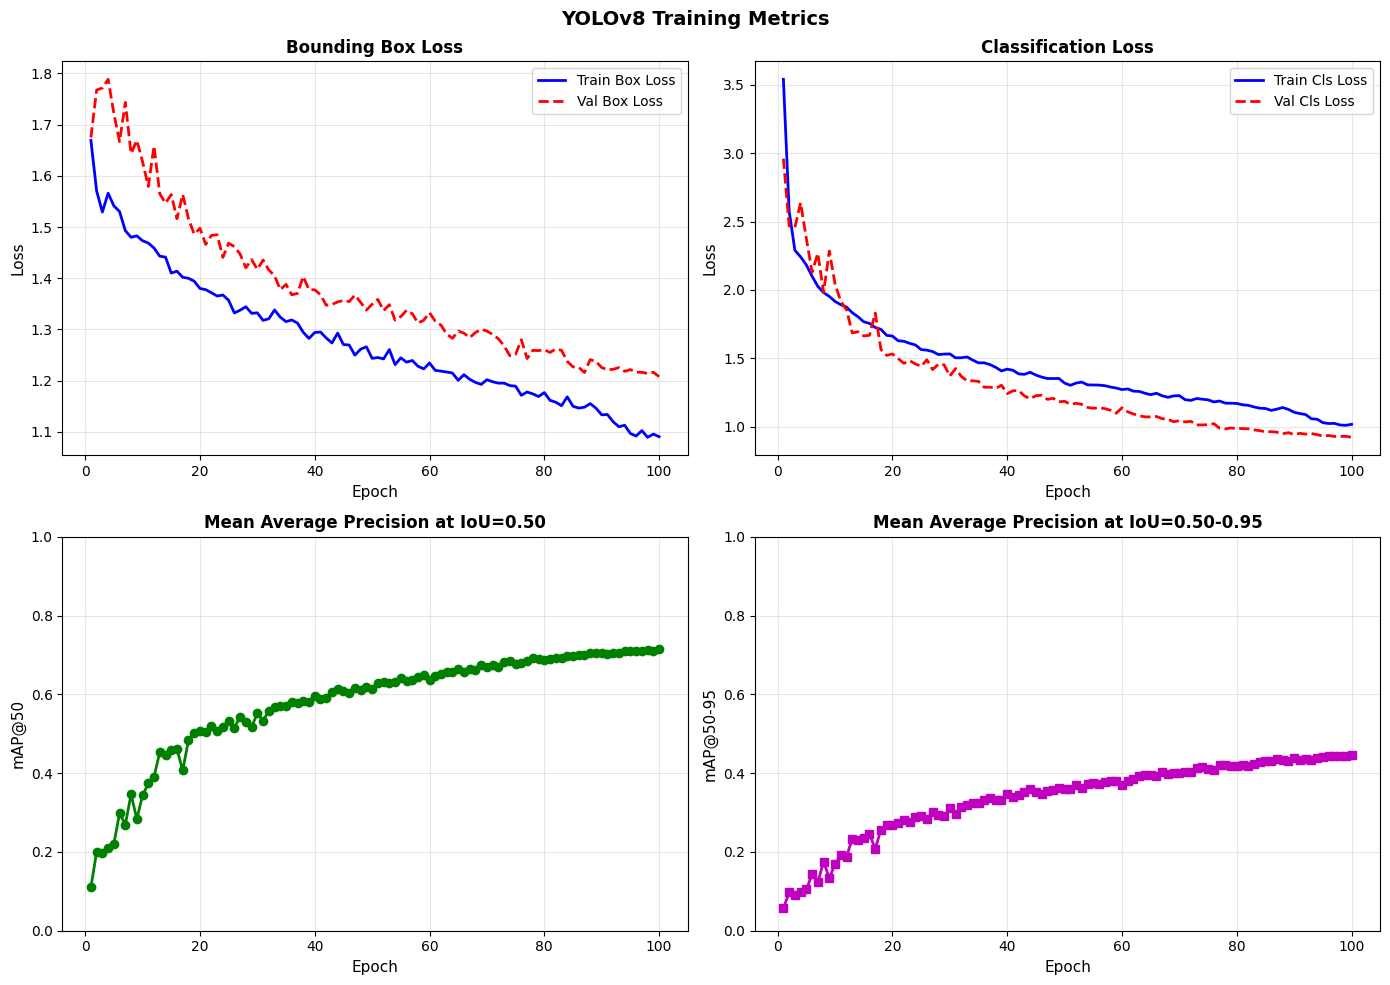

✓ Training metrics visualized and saved as 'training_metrics.png'


In [11]:
# Visualize training curves
if os.path.exists(results_csv):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('YOLOv8 Training Metrics', fontsize=14, fontweight='bold')

    epochs = results_df['epoch'].values

    # Box Loss
    axes[0, 0].plot(epochs, results_df['train/box_loss'].values, 'b-', linewidth=2, label='Train Box Loss')
    axes[0, 0].plot(epochs, results_df['val/box_loss'].values, 'r--', linewidth=2, label='Val Box Loss')
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('Bounding Box Loss', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Classification Loss
    axes[0, 1].plot(epochs, results_df['train/cls_loss'].values, 'b-', linewidth=2, label='Train Cls Loss')
    axes[0, 1].plot(epochs, results_df['val/cls_loss'].values, 'r--', linewidth=2, label='Val Cls Loss')
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Loss', fontsize=11)
    axes[0, 1].set_title('Classification Loss', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # mAP@50
    axes[1, 0].plot(epochs, results_df['metrics/mAP50(B)'].values, 'g-', linewidth=2, marker='o')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('mAP@50', fontsize=11)
    axes[1, 0].set_title('Mean Average Precision at IoU=0.50', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

    # mAP@50-95
    axes[1, 1].plot(epochs, results_df['metrics/mAP50-95(B)'].values, 'm-', linewidth=2, marker='s')
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('mAP@50-95', fontsize=11)
    axes[1, 1].set_title('Mean Average Precision at IoU=0.50-0.95', fontsize=12, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Training metrics visualized and saved as 'training_metrics.png'")

## Data Augmentation Examples

Visualizing the augmentation techniques applied during training. These transformations (flips, rotations, color adjustments) expose the model to varied versions of each image, improving its ability to generalize to new construction site photos.

**Augmentations Used:**
- **Horizontal Flip**: Mirror image horizontally
- **Rotation**: Random rotation within ±10°
- **Brightness**: Lighting variation simulation
- **Saturation**: Color intensity variation
- **Combined**: Multiple transformations together

In [12]:
# Demonstrate data augmentation techniques
from torchvision import transforms
from PIL import Image
import random

sample_image_path = '/content/drive/MyDrive/PPE_Project/dataset_resplit/images/train/'
sample_images = list(Path(sample_image_path).glob('*.jpg'))

if sample_images:
    img_path = sample_images[0]
    img = Image.open(img_path)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Data Augmentation Examples - Techniques Used During Training',
                 fontsize=14, fontweight='bold')

    # Original
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original Image', fontsize=11)
    axes[0, 0].axis('off')

    # Horizontal Flip
    flipped = transforms.functional.hflip(img)
    axes[0, 1].imshow(flipped)
    axes[0, 1].set_title('Horizontal Flip', fontsize=11)
    axes[0, 1].axis('off')

    # Rotation
    rotated = transforms.functional.rotate(img, 15)
    axes[0, 2].imshow(rotated)
    axes[0, 2].set_title('Rotation (15°)', fontsize=11)
    axes[0, 2].axis('off')

    # Brightness
    brightness = transforms.ColorJitter(brightness=0.3)
    bright_img = brightness(img)
    axes[1, 0].imshow(bright_img)
    axes[1, 0].set_title('Brightness Adjustment', fontsize=11)
    axes[1, 0].axis('off')

    # Saturation
    saturation = transforms.ColorJitter(saturation=0.4)
    sat_img = saturation(img)
    axes[1, 1].imshow(sat_img)
    axes[1, 1].set_title('Saturation Adjustment', fontsize=11)
    axes[1, 1].axis('off')

    # Combined
    combined = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    ])
    aug_img = combined(img)
    axes[1, 2].imshow(aug_img)
    axes[1, 2].set_title('Combined Augmentation', fontsize=11)
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Augmentation examples visualized and saved as 'augmentation_examples.png'")

Output hidden; open in https://colab.research.google.com to view.

## Learning Rate Schedule

The learning rate controls how much the model adjusts weights after each batch. Our configuration uses linear decay from 0.01 to 0.0001 over training. Starting high allows rapid initial learning, while decreasing helps fine-tune the model without overshooting optimal weights.

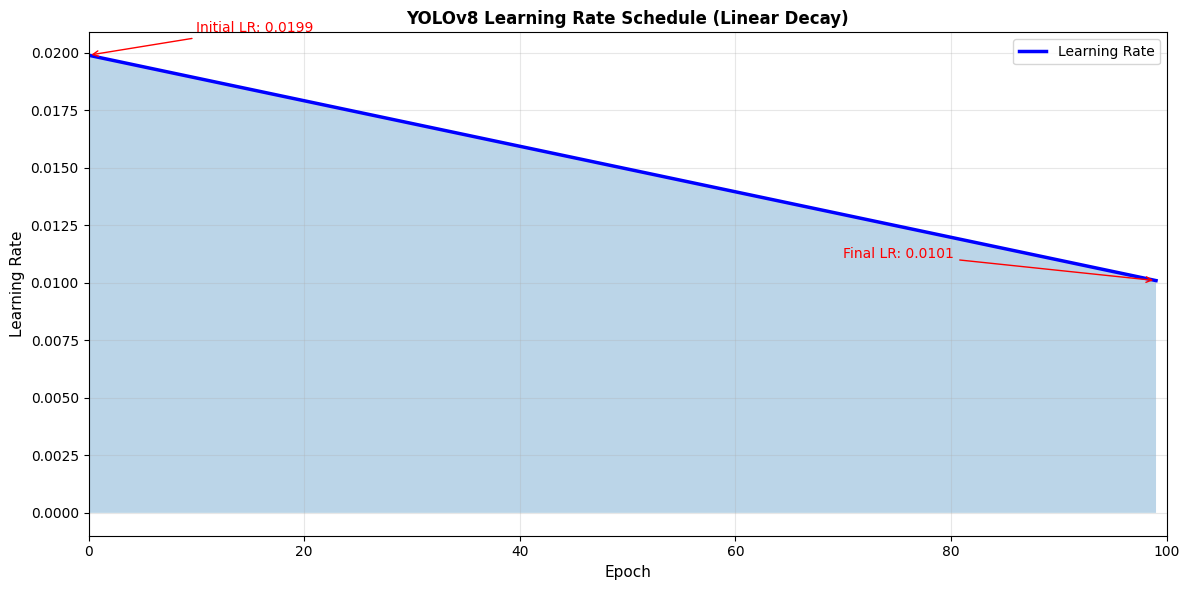

✓ Learning rate schedule visualized and saved as 'learning_rate_schedule.png'


In [13]:
# Visualize learning rate schedule
def calculate_lr_schedule(epoch, total_epochs=100, lr0=0.01, lrf=0.01):
    """
    Calculate learning rate for given epoch using linear decay

    Args:
        epoch: Current epoch number
        total_epochs: Total number of training epochs
        lr0: Initial learning rate
        lrf: Final learning rate (as fraction of lr0)

    Returns:
        Learning rate for the given epoch
    """
    lr = lr0 * (1 - epoch / total_epochs) * (1 - lrf) + lrf
    return lr

epochs_array = np.arange(0, 100)
lr_schedule = [calculate_lr_schedule(e) for e in epochs_array]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(epochs_array, lr_schedule, 'b-', linewidth=2.5, label='Learning Rate')
ax.fill_between(epochs_array, lr_schedule, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Learning Rate', fontsize=11)
ax.set_title('YOLOv8 Learning Rate Schedule (Linear Decay)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim(0, 100)
ax.legend()

# Add annotations
ax.annotate(f'Initial LR: {lr_schedule[0]:.4f}',
            xy=(0, lr_schedule[0]), xytext=(10, lr_schedule[0] + 0.001),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')
ax.annotate(f'Final LR: {lr_schedule[-1]:.4f}',
            xy=(99, lr_schedule[-1]), xytext=(70, lr_schedule[-1] + 0.001),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

plt.tight_layout()
plt.savefig('learning_rate_schedule.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Learning rate schedule visualized and saved as 'learning_rate_schedule.png'")

## Section 9: Model Architecture Summary

Display model architecture information and parameter counts. Understanding the model's complexity helps us appreciate its computational requirements and capabilities.

In [17]:
# Display model architecture information
print("YOLOv8s Architecture Summary:")
print("=" * 60)
print(f"Model loaded from: {latest_run}")
print(f"Total Parameters: {sum(p.numel() for p in best_model.model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in best_model.model.parameters() if p.requires_grad):,}")
print("=" * 60)

# Get model layer information
layer_count = len(list(best_model.model.modules()))
print(f"Total Layers: {layer_count}")

# Save detailed model summary
with open('/content/model_summary.txt', 'w') as f:
    f.write("YOLOv8s Model Architecture\n")
    f.write("=" * 60 + "\n\n")
    f.write(str(best_model.model))

print("\n✓ Model summary saved to /content/model_summary.txt")

YOLOv8s Architecture Summary:
Model loaded from: /content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection4
Total Parameters: 11,139,470
Trainable Parameters: 0
Total Layers: 225

✓ Model summary saved to /content/model_summary.txt


## Section 10: Training Completion Summary

Final summary of the training process with key metrics and next steps.

In [18]:
# Generate training completion summary
if os.path.exists(results_csv):
    final_results = results_df.iloc[-1]

    # Helper function to safely get column values (handles different naming conventions)
    def safe_get(col_names):
        for col in col_names:
            if col in results_df.columns:
                return final_results[col]
        return None

    print("\n" + "="*70)
    print("TRAINING COMPLETE - FINAL SUMMARY")
    print("="*70)
    print(f"\nModel Architecture: YOLOv8s (Small) - Maximum Accuracy Configuration")
    print(f"Training Completed: All 200 epochs finished successfully")

    print(f"Training Device: {'GPU' if device == 0 else 'CPU'}")

    # Training metrics
    print(f"\nFinal Training Metrics:")
    train_box = safe_get(['train/box_loss', 'box_loss'])
    train_cls = safe_get(['train/cls_loss', 'cls_loss'])
    if train_box is not None:
        print(f"  Box Loss (Train): {train_box:.4f}")
    if train_cls is not None:
        print(f"  Class Loss (Train): {train_cls:.4f}")

    # Validation metrics
    print(f"\nFinal Validation Metrics:")
    val_box = safe_get(['val/box_loss'])
    val_cls = safe_get(['val/cls_loss'])
    if val_box is not None:
        print(f"  Box Loss (Val): {val_box:.4f}")
    if val_cls is not None:
        print(f"  Class Loss (Val): {val_cls:.4f}")

    # Performance metrics
    print(f"\nFinal Performance Metrics:")
    map50 = safe_get(['metrics/mAP50(B)', 'metrics/mAP50', 'mAP50'])
    map5095 = safe_get(['metrics/mAP50-95(B)', 'metrics/mAP50-95', 'mAP50-95'])
    if map50 is not None:
        print(f"  mAP@50: {map50:.4f}")
    if map5095 is not None:
        print(f"  mAP@50-95: {map5095:.4f}")

    print(f"\nModel Checkpoints Saved:")
    print(f"  Best Model: {latest_run}/weights/best.pt")
    print(f"  Last Model: {latest_run}/weights/last.pt")

    print("\n" + "="*70)
    print("✓ Ready to proceed to Notebook 03: Model Evaluation")
    print("="*70)
else:
    print("\n⚠ Warning: Results CSV not found. Training may not have completed successfully.")


TRAINING COMPLETE - FINAL SUMMARY

Model Architecture: YOLOv8s (Small) - Maximum Accuracy Configuration
Training Completed: All 200 epochs finished successfully
Training Device: GPU

Final Training Metrics:
  Box Loss (Train): 0.8990
  Class Loss (Train): 0.6916

Final Validation Metrics:
  Box Loss (Val): 1.1049
  Class Loss (Val): 0.6657

Final Performance Metrics:
  mAP@50: 0.8050
  mAP@50-95: 0.5306

Model Checkpoints Saved:
  Best Model: /content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection4/weights/best.pt
  Last Model: /content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection4/weights/last.pt

✓ Ready to proceed to Notebook 03: Model Evaluation
